In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score
import random

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

In [4]:
import numpy as np
import pandas as pd

# Load syllables to keep
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

# Process males data
df_male = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df_male = df_male[keep_syllables].groupby(['age', 'uuid', 'mouse']).mean()

# Bin ages by week and handle first and last samples
ages = df_male.index.get_level_values('age')
weeks = (ages * 7) // 7
df_male['binned_age'] = weeks

sample_male_first = df_male.groupby(['mouse', 'binned_age']).first().reset_index()
sample_male_last = df_male.groupby(['mouse', 'binned_age']).last().reset_index()
sample_male_last['binned_age'] += 0.5

# Concatenate first and last samples
df_male_combined = pd.concat([sample_male_first, sample_male_last])
df_male_combined.rename(columns={'binned_age': 'age'}, inplace=True)
df_male_combined.set_index(['age', 'mouse'], inplace=True)

# Average per age or session
m_df = df_male_combined.groupby(['age', 'mouse']).mean()
m_df['sex'] = 'm'
m_df.set_index('sex', append=True, inplace=True)

# Process females data
df_female = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df_female = df_female[keep_syllables].groupby(['age', 'uuid', 'mouse']).mean()

# Bin ages by week and handle first and last samples
ages = df_female.index.get_level_values('age')
weeks = (ages * 7) // 7
df_female['binned_age'] = weeks

sample_female_first = df_female.groupby(['mouse', 'binned_age']).first().reset_index()
sample_female_last = df_female.groupby(['mouse', 'binned_age']).last().reset_index()
sample_female_last['binned_age'] += 0.5

# Concatenate first and last samples
df_female_combined = pd.concat([sample_female_first, sample_female_last])
df_female_combined.rename(columns={'binned_age': 'age'}, inplace=True)
df_female_combined.set_index(['age', 'mouse'], inplace=True)

# Average per age or session
f_df = df_female_combined.groupby(['age', 'mouse']).mean()
f_df['sex'] = 'f'
f_df.set_index('sex', append=True, inplace=True)

f_df = f_df.query('mouse!="F4_03"')

# Combine male and female data into a single DataFrame
combined_df = pd.concat([m_df, f_df])

In [5]:
format_plots()

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Parameters
N_SPLIT = 5
N_REP = 20
N_SHUFFLE = 100
WINDOW_SIZE = 8

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=10, kernel='linear'))
])

# Function to perform rolling window analysis using a pipeline
def rolling_window_classification(df, pipeline, window_size=8):
    results = []
    shuffle_results = []
    ages = df.index.get_level_values('age').unique()
    
    for i in tqdm(range(len(ages) - window_size + 1), desc="Rolling Window Classification Progress"):
        window_ages = ages[i:i + window_size]
        window_data = df.loc[df.index.get_level_values('age').isin(window_ages)]
        center_age = np.mean(window_ages)
        
        for sex in np.unique(window_data.index.get_level_values('sex')):
            sex_data = window_data[window_data.index.get_level_values('sex') == sex]
            X_sex = sex_data.values
            y_sex = sex_data.index.get_level_values('mouse')
            
            # Original classification
            for j in range(N_REP):
                skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=j)
                y_pred = cross_val_predict(pipeline, X_sex, y_sex, cv=skf, n_jobs=-1)
                results.append((center_age, accuracy_score(y_sex,y_pred), sex))
             
            # Shuffled classifications
            for j in range(N_SHUFFLE):
                y_shuffled = np.random.permutation(y_sex)
                skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=j)
                y_pred_shuff = cross_val_predict(pipeline, X_sex, y_shuffled, cv=skf, n_jobs=-1)
                shuffle_results.append((center_age, accuracy_score(y_shuffled,y_pred_shuff), sex))
    
    return results, shuffle_results

# Run the rolling window classification for combined data
results, shuffle_results = rolling_window_classification(combined_df, pipeline, window_size=WINDOW_SIZE)
results_df = pd.DataFrame(results, columns=['age', 'accuracy', 'sex'])
shuffle_df = pd.DataFrame(shuffle_results, columns=['age', 'accuracy', 'sex'])

Rolling Window Classification Progress:  42%|██████████████████████████████████████████████████████▋                                                                          | 36/85 [03:31<04:47,  5.87s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
Rolling Window Classification Progress:  47%|████████████████████████████████████████████████████████████▋                                          

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

Rolling Window Classification Progress:  66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 56/85 [05:27<02:49,  5.85s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
Rolling Window Classification Progress:  73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 62/85 [06:01<02:13,  5.82s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

Rolling Window Classification Progress:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 63/85 [06:07<02:09,  5.89s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

Rolling Window Classification Progress:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 69/85 [06:42<01:28,  5.55s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
Rolling Window Classification Progress:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 80/85 [07:47<00:29,  5.95s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

Rolling Window Classification Progress:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 81/85 [07:53<00:23,  5.85s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

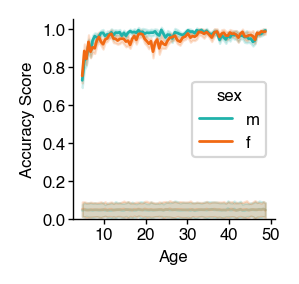

In [7]:
# Plot accuracy scores
fig=plt.figure(figsize=(1.3, 1.3))

# Plot shuffled results
sns.lineplot(data=shuffle_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], alpha=0.25, legend=False, errorbar=('sd', 2))

# Plot original results
sns.lineplot(data=results_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], errorbar=('sd', 2))

plt.xlabel('Age')
plt.ylabel('Accuracy Score')
plt.ylim([0, 1.05])
plt.xticks([10, 20, 30, 40, 50])
sns.despine()
plt.show()

In [8]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '07_15_indv_decoder_longv2.pdf')

In [9]:
## last data point prediction

In [10]:
# Parameters
N_SPLIT = 5
N_REP = 20
N_SHUFFLE = 100
WINDOW_SIZE = 8
N_TEST_SESSIONS = 8

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=10, kernel='linear'))
])

def rolling_window_classification(df, pipeline, window_size=8, n_test_sessions=2):
    results = []
    shuffle_results = []
    ages = df.index.get_level_values('age').unique()
    
    # Identify the last n sessions for testing
    test_sessions = ages[-n_test_sessions:]
    
    for i in tqdm(range(len(ages) - window_size - n_test_sessions + 1), desc="Rolling Window Classification Progress"):
        window_ages = ages[i:i + window_size]
        window_data = df.loc[df.index.get_level_values('age').isin(window_ages)]
        center_age = np.mean(window_ages)
        
        # Get test data (always the same last n sessions)
        test_data = df.loc[df.index.get_level_values('age').isin(test_sessions)]
        
        for sex in np.unique(window_data.index.get_level_values('sex')):
            train_data = window_data[window_data.index.get_level_values('sex') == sex]
            X_train = train_data.values
            y_train = train_data.index.get_level_values('mouse')
            
            test_data_sex = test_data[test_data.index.get_level_values('sex') == sex]
            X_test = test_data_sex.values
            y_test = test_data_sex.index.get_level_values('mouse')
            
            # Original classification
            for j in range(N_REP):
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)
                results.append((center_age, accuracy_score(y_test, y_pred), sex))
             
            # Shuffled classifications
            for j in range(N_SHUFFLE):
                y_train_shuffled = np.random.permutation(y_train)
                y_test_shuffled = np.random.permutation(y_test)
                pipeline.fit(X_train, y_train_shuffled)
                y_pred_shuff = pipeline.predict(X_test)
                shuffle_results.append((center_age, accuracy_score(y_test_shuffled, y_pred_shuff), sex))
    
    return results, shuffle_results

# Run the rolling window classification for combined data
results, shuffle_results = rolling_window_classification(combined_df, pipeline, window_size=WINDOW_SIZE, n_test_sessions=N_TEST_SESSIONS)
results_df = pd.DataFrame(results, columns=['age', 'accuracy', 'sex'])
shuffle_df = pd.DataFrame(shuffle_results, columns=['age', 'accuracy', 'sex'])

Rolling Window Classification Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [03:37<00:00,  2.82s/it]


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

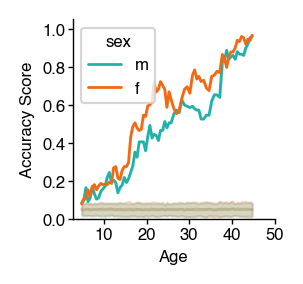

In [13]:
# Plot accuracy scores
fig=plt.figure(figsize=(1.3, 1.3))

# Plot shuffled results
sns.lineplot(data=shuffle_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], alpha=0.25, legend=False, errorbar=('sd', 2))

# Plot original results
sns.lineplot(data=results_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], errorbar=('sd', 2))

plt.xlabel('Age')
plt.ylabel('Accuracy Score')
plt.ylim([0, 1.05])
plt.xticks([10, 20, 30, 40, 50])
sns.despine()
plt.show()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '07_15_indv_decoder_longv2_TEST_LAST_POINT.pdf')